In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns; sns.set(style="white", font_scale=2)

import numpy as np
import pandas as pd
from astropy.io import fits
import glob


from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers.noise import GaussianNoise
from keras.utils import np_utils
from keras.constraints import maxnorm


from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
K.set_image_data_format('channels_first')

Using TensorFlow backend.


In [2]:
# give access to importing dwarfz
import os, sys
dwarfz_package_dir = os.getcwd().split("dwarfz")[0]
if dwarfz_package_dir not in sys.path:
    sys.path.insert(0, dwarfz_package_dir)

import dwarfz
    
# back to regular import statements

# To Do
 1. Read in fits images
 2. crop image smaller
 3. Combine filters into one cube
 4. Apply pre-processing stretch (asinh)
 5. Create training set with labels
 6. Set up keras model
 7. Poke around at the results
 
 

# 0) Get files

In [3]:
HSC_ids = [int(os.path.split(os.path.split(image_dir)[0])[1])
           for image_dir in glob.glob("../../images-first-sample/*/HSC-G")]
HSC_ids = np.array(sorted(HSC_ids))

In [4]:
HSC_id = HSC_ids[0] # for when I need a single sample galaxy

In [5]:
bands = ["g", "r", "i", "z", "y"]

# 1) Read in fits image


In [6]:
def get_image(HSC_id, band):
    """Reads a single image from its fits file
    Inputs
    ------
        HSC_id : int
        band : str
            valid options: 'g', 'r', 'i' , 'z', 'y'
            case-insensitive
    """
    
    images_dir = os.path.join("../../images-first-sample/",
                              str(HSC_id)
                             )
    if not os.path.isdir(images_dir):
        raise FileNotFoundError("Can't find dir: {}".format(images_dir))
    
    filename = os.path.join(images_dir, 
                            "HSC-{}".format(band.upper()),
                            "eric_{}_HSC-{}_full_img.fits".format(str(HSC_id), band.upper()),
                           )
    
    hdulist = fits.open(filename)
    image = hdulist[0].data
    return image

image = get_image(HSC_id, "g")

In [7]:
def image_plotter(image, reverse_cmap=False):
    cmap = "viridis_r" if reverse_cmap else "viridis"
    
    plt.imshow(image,
               cmap=plt.get_cmap(cmap)
               )
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())


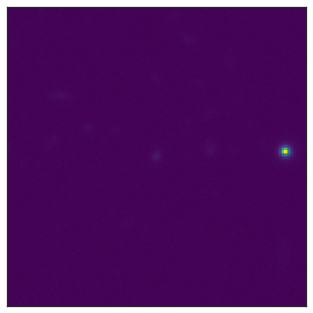

In [8]:
image_plotter(image)

/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


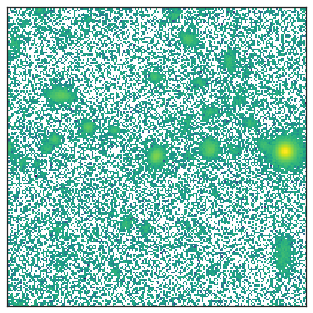

In [9]:
image_plotter(np.log(image))

# 2) Crop Image

In [10]:
def get_cutout(image, cutout_size = 20):
    image_shape = image.shape

    center_index = (image_shape[0]//2, image_shape[1]//2)

    # Check that these are actually x and y ordered
    min_x = center_index[0] - (cutout_size//2)
    max_x = center_index[0] + (cutout_size//2)
    min_y = center_index[1] - (cutout_size//2)
    max_y = center_index[1] + (cutout_size//2)

    cutout = image[min_x:max_x, min_y:max_y]
    
    return cutout


In [11]:
cutout = get_cutout(image)
cutout.shape

(20, 20)

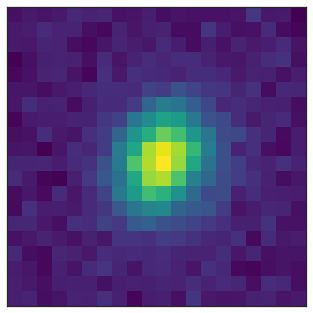

In [12]:
image_plotter(cutout)

# 3) Apply stretch

Base this off the asinh magnitude system of [Lupton, Gunn and Szalay (1999)](http://iopscience.iop.org/article/10.1086/301004/meta) used for SDSS. (It's expliticly given in the [SDSS Algorithms](http://classic.sdss.org/dr7/algorithms/fluxcal.html) documentation as well as [this overview page](https://ned.ipac.caltech.edu/help/sdss/dr6/photometry.html#asinh)).

$$ \mathrm{mag}_\mathrm{asinh} = - \left(\frac{2.5}{\ln(10)}\right) \left(\mathrm{asinh}\left(\frac{f/f_0}{2b}\right) + \ln(b) \right)$$

for softening parameter $b$, and reference flux (f_0).

**NOTE** that I am looking at _surface brightness_ (mag / arcsec$^2$), not actual magnitudes. Also I don't care about the reference flux, as long as my colors are reasonably well preserved. Later I should look into using the correct reference flux (to make sure colors are preserved properly), but I'm not doing that yet.

In [13]:
# later, these should be set programmatically
reference_flux = .2
softening = 1e-1

In [14]:
def asinh_stretch(data, reference_flux, softening):
    return (-2.5/np.log(10)) * (np.arcsinh(data/reference_flux /(2*softening)) + np.log(softening))

In [15]:
cutout_stretched = asinh_stretch(cutout, reference_flux, softening)

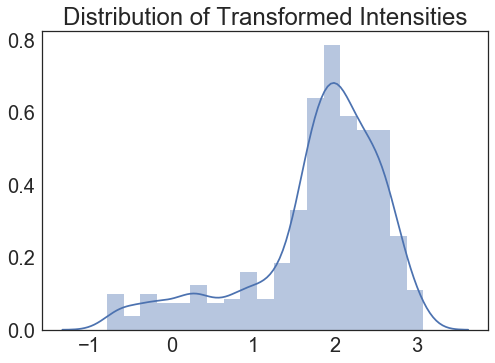

In [16]:
sns.distplot(cutout_stretched.flatten())
plt.title("Distribution of Transformed Intensities")

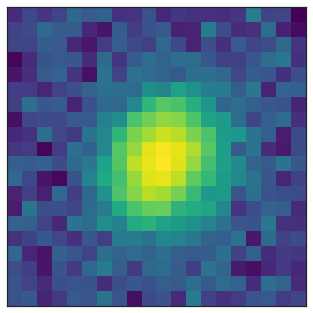

In [17]:
image_plotter(cutout_stretched, reverse_cmap=True)


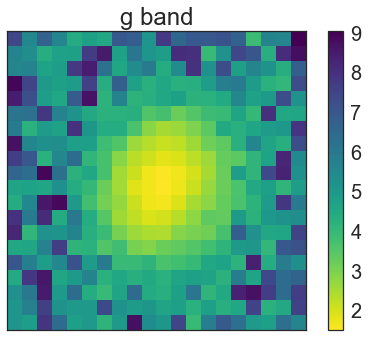

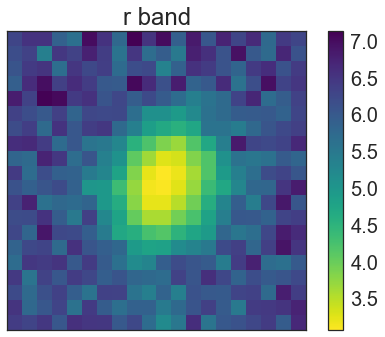

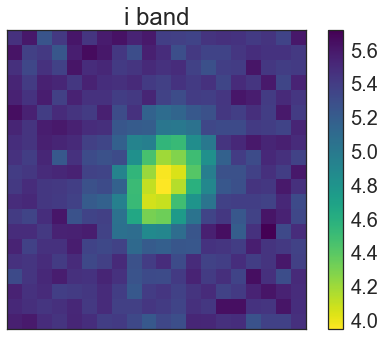

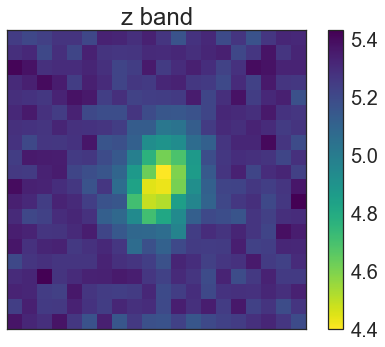

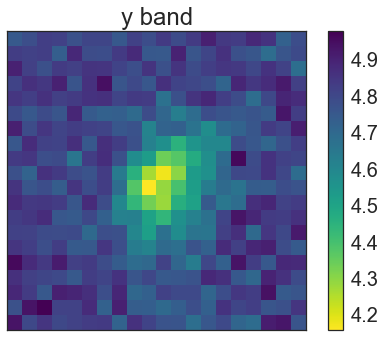

In [18]:
for band in bands:
    image = get_image(HSC_id, band)
    cutout = get_cutout(image)
    cutout_stretched = asinh_stretch(cutout, np.max(image)/4, np.median(image))

    plt.figure()
    image_plotter(cutout_stretched, reverse_cmap=True)
    plt.title("{} band".format(band))
    plt.colorbar()

# 4) Combine filters into cube

In [19]:
images = [None]*len(bands)
cutouts = [None]*len(bands)
for i, band in enumerate(bands):
    images[i] = get_image(HSC_id, band)
    cutouts[i] = get_cutout(images[i])

In [20]:
cutout_cube = np.array(cutouts)
cutout_cube_stretched = asinh_stretch(cutout_cube, reference_flux, softening)

In [21]:
cutout_cube.shape

(5, 20, 20)

# 5) Create Training set with labels

In [22]:
COSMOS_filename = os.path.join(dwarfz.data_dir_default, "COSMOS_reference.sqlite")
COSMOS = dwarfz.datasets.COSMOS(COSMOS_filename)

In [23]:
matches_filename = os.path.join(dwarfz.data_dir_default, "matches.sqlite3")
matches_df = dwarfz.matching.Matches.load_from_filename(matches_filename)

In [24]:
combined = matches_df[matches_df.match].copy()
combined["ra"]       = COSMOS.df.loc[combined.index].ra
combined["dec"]      = COSMOS.df.loc[combined.index].dec
combined["photo_z"]  = COSMOS.df.loc[combined.index].photo_z
combined["log_mass"] = COSMOS.df.loc[combined.index].mass_med
combined["target"]   = (combined.photo_z < 0.15) & (combined.log_mass < 9)

In [25]:
combined = combined.set_index("catalog_2_ids")

In [26]:
combined.head()

,sep,match,error,ra,dec,photo_z,log_mass,target
catalog_2_ids,,,,,,,,
43158996781122114,0.114389,True,False,149.749393,1.618068,0.3797,11.07610,False
43158447025298860,0.471546,True,False,150.388349,1.614538,2.3343,8.99275,False
43158447025298862,0.202378,True,False,150.402935,1.614631,2.1991,9.71373,False
43158584464246387,0.207967,True,False,150.295083,1.614662,2.4407,9.77811,False
43158584464253383,0.295316,True,False,150.239919,1.614675,0.2079,7.04224,False


In [27]:
X = np.empty((len(HSC_ids), *cutout_cube.shape))
X.shape

(200, 5, 20, 20)

In [28]:
X = np.empty((len(HSC_ids), *cutout_cube.shape))
print("X.shape: ", X.shape)

for i, HSC_id in enumerate(HSC_ids):
    images = [None]*len(bands)
    cutouts = [None]*len(bands)
    for j, band in enumerate(bands):
        images[j] = get_image(HSC_id, band)
        cutouts[j] = get_cutout(images[j])
    cutout_cube = np.array(cutouts)
    cutout_cube_stretched = asinh_stretch(cutout_cube, reference_flux, softening)
    
    X[i,:, ...] = cutout_cube_stretched


X.shape:  (200, 5, 20, 20)


In [29]:
Y = combined.loc[HSC_ids].target.values
Y

array([False,  True, False,  True,  True, False, False, False, False,
        True, False,  True, False,  True, False, False,  True,  True,
       False, False,  True, False, False, False, False, False,  True,
        True,  True,  True, False,  True, False, False,  True,  True,
       False, False, False, False,  True, False, False,  True,  True,
       False, False,  True, False, False, False, False, False,  True,
       False, False, False, False, False, False, False,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False,  True,
        True, False,  True,  True,  True,  True, False, False, False,
        True, False, False, False,  True, False, False,  True, False,
       False, False, False, False, False,  True,  True,  True, False,
       False, False, False, False,  True, False, False, False, False,
        True,  True,

In [30]:
Y.mean()

0.32000000000000001

## 5b) Split training and testing set

In [31]:
randomized_indices = np.arange(X.shape[0])
np.random.shuffle(randomized_indices)


testing_fraction = 0.3
test_set_indices = randomized_indices[:int(testing_fraction*X.shape[0])]
training_set_indices = np.array(list(set([*randomized_indices]) - set([*test_set_indices])))

In [32]:
test_set_indices.size

60

In [33]:
training_set_indices.size

140

# 6) Set up `keras` model

In [34]:
n_conv_filters = 16
conv_kernel_size = 4
input_shape = cutout_cube.shape

dropout_fraction = .25

In [35]:
model = Sequential()
model.add(Conv2D(n_conv_filters, conv_kernel_size,
                        padding='same', input_shape=input_shape))
model.add(Activation('relu'))
# model.add(Conv2D(depth, 3, 3))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_fraction))
model.add(Flatten())
# model.add(Dense(2*nb_dense))
# model.add(Dense(nb_dense))
model.add(Dense(1, activation="sigmoid"))

In [36]:
learning_rate = 0.01
decay = 0
momentum = 0.9

sgd = SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)

In [37]:
model.compile(loss='binary_crossentropy',optimizer=sgd)


In [38]:
earlystopping = EarlyStopping(monitor='val_loss',patience=2,verbose=0,mode='auto' )


In [39]:
# modelcheckpoint = ModelCheckpoint(pathinCat+'Models/bestmodelMAG.hdf5',monitor='val_loss',verbose=0,save_best_only=True)


## 6b) Subclass NumpyArrayIterator
The original only allowed 1, 3 or 4 channel images. I have 5 channel images.

In [40]:
from keras.preprocessing.image import NumpyArrayIterator


In [41]:
class NumpyArrayIteratorNChannels(NumpyArrayIterator):
    """A subclass of `keras.preprocessing.image.NumpyArrayIterator`
    except this version doesn't check the number of image channels within 
    self.__init__()
    
    This was adapted on 23 May 2017. If it's been a long time since then,
    you probably want to refresh this class off the current source for keras
    
    The only thing that was changed was the __init__() constructor method
    """

    def __init__(self, x, y, image_data_generator,
                 batch_size=32, shuffle=False, seed=None,
                 data_format=None,
                 save_to_dir=None, save_prefix='', save_format='png'):
        if y is not None and len(x) != len(y):
            raise ValueError('X (images tensor) and y (labels) '
                             'should have the same length. '
                             'Found: X.shape = %s, y.shape = %s' %
                             (np.asarray(x).shape, np.asarray(y).shape))

        if data_format is None:
            data_format = K.image_data_format()
        self.x = np.asarray(x, dtype=K.floatx())

        if self.x.ndim != 4:
            raise ValueError('Input data in `NumpyArrayIterator` '
                             'should have rank 4. You passed an array '
                             'with shape', self.x.shape)
        channels_axis = 3 if data_format == 'channels_last' else 1
#         if self.x.shape[channels_axis] not in {1, 3, 4}:
#             raise ValueError('NumpyArrayIterator is set to use the '
#                              'data format convention "' + data_format + '" '
#                              '(channels on axis ' + str(channels_axis) + '), i.e. expected '
#                              'either 1, 3 or 4 channels on axis ' + str(channels_axis) + '. '
#                              'However, it was passed an array with shape ' + str(self.x.shape) +
#                              ' (' + str(self.x.shape[channels_axis]) + ' channels).')
        if y is not None:
            self.y = np.asarray(y)
        else:
            self.y = None
        self.image_data_generator = image_data_generator
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        super(NumpyArrayIterator, self).__init__(x.shape[0], batch_size, shuffle, seed)

## 6c) Subclass ImageDataGenerator
The original only allowed 1, 3 or 4 channel images. I have 5 channel images.

In [42]:
from keras.preprocessing.image import ImageDataGenerator


In [43]:
class ImageDataGeneratorNChannels(ImageDataGenerator):
    """Subclasses `keras.preprocessing.image.ImageDataGenerator`
    to provide support for images with arbitrary numbers of channels.
    
    Everything is the same, except the `.fit()` method (which has the 
    channels check disabled) and the `.flow()` method (which calls
    `NumpyArrayIteratorNChannels`, a subclass I adapted, rather than 
    `NumpyArrayIterator` which also checsk the number of channels)
    
    This class adapted using the master branch on 23 May 2017.
    If it's been a while since then, you should probably check to see if anything 
    major has changed to `ImageDataGenerator`, especially the `.fit()` and 
    `.flow()` methods
    """
    def __init__(self, **params):
        super(ImageDataGeneratorNChannels, self).__init__(**params)
        
    def fit(self, x,
            augment=False,
            rounds=1,
            seed=None):
        """Fits internal statistics to some sample data.

        Required for featurewise_center, featurewise_std_normalization
        and zca_whitening.

        # Arguments
            x: Numpy array, the data to fit on. Should have rank 4.
                In case of grayscale data,
                the channels axis should have value 1, and in case
                of RGB data, it should have value 3.
            augment: Whether to fit on randomly augmented samples
            rounds: If `augment`,
                how many augmentation passes to do over the data
            seed: random seed.

        # Raises
            ValueError: in case of invalid input `x`.
        """
        x = np.asarray(x, dtype=K.floatx())
        if x.ndim != 4:
            raise ValueError('Input to `.fit()` should have rank 4. '
                             'Got array with shape: ' + str(x.shape))
#         if x.shape[self.channel_axis] not in {1, 3, 4}:
#             raise ValueError(
#                 'Expected input to be images (as Numpy array) '
#                 'following the data format convention "' + self.data_format + '" '
#                 '(channels on axis ' + str(self.channel_axis) + '), i.e. expected '
#                 'either 1, 3 or 4 channels on axis ' + str(self.channel_axis) + '. '
#                 'However, it was passed an array with shape ' + str(x.shape) +
#                 ' (' + str(x.shape[self.channel_axis]) + ' channels).')

        if seed is not None:
            np.random.seed(seed)

        x = np.copy(x)
        if augment:
            ax = np.zeros(tuple([rounds * x.shape[0]] + list(x.shape)[1:]), dtype=K.floatx())
            for r in range(rounds):
                for i in range(x.shape[0]):
                    ax[i + r * x.shape[0]] = self.random_transform(x[i])
            x = ax

        if self.featurewise_center:
            self.mean = np.mean(x, axis=(0, self.row_axis, self.col_axis))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.mean = np.reshape(self.mean, broadcast_shape)
            x -= self.mean

        if self.featurewise_std_normalization:
            self.std = np.std(x, axis=(0, self.row_axis, self.col_axis))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.std = np.reshape(self.std, broadcast_shape)
            x /= (self.std + K.epsilon())

        if self.zca_whitening:
            flat_x = np.reshape(x, (x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))
            sigma = np.dot(flat_x.T, flat_x) / flat_x.shape[0]
            u, s, _ = linalg.svd(sigma)
            self.principal_components = np.dot(np.dot(u, np.diag(1. / np.sqrt(s + self.zca_epsilon))), u.T)


    def flow(self, x, y=None, batch_size=32, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='png'):
        return NumpyArrayIteratorNChannels(
            x, y, self,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format)


## 6d) Create Data Generator

In [44]:
print('Using real-time data augmentation.')
# this will do preprocessing and realtime data augmentation
datagen = ImageDataGeneratorNChannels(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,  # randomly flip images
#     nchannels=5,  # number of image filters
)   

Using real-time data augmentation.


 **NOTE** `keras` can't deal with arbitrary numbers of image channels right now (it only supports 1, 3 or 4 layered images). -\_-  Right now I've commented out this restriction in the source code (`keras/preprocessing/image.py`), but haven't tried a pull request
 
 **To do:** rather than issuing a pull request (which has been ignored), how about I just subclass the keras generator?

In [45]:
datagen.fit(X[training_set_indices])

# 7) Run basic keras model

In [46]:
steps_per_epoch = max(2, training_set_indices.size//50)
batch_size = training_set_indices.size//steps_per_epoch
print("steps_per_epoch: ", steps_per_epoch)
print("batch_size: ", batch_size)
epochs = 10
verbose=1

steps_per_epoch:  2
batch_size:  70


In [47]:
history = model.fit_generator(datagen.flow(X[training_set_indices], Y[training_set_indices],
                                           batch_size=batch_size,
                                          ),
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=(X[test_set_indices], Y[test_set_indices]),
                              verbose=verbose,
                              callbacks=[earlystopping],
                              )  

Epoch 1/10
2/2 [==============================] - 3s - loss: 0.6535 - val_loss: 0.7919
Epoch 2/10
2/2 [==============================] - 0s - loss: 1.6802 - val_loss: 0.5038
Epoch 3/10
2/2 [==============================] - 0s - loss: 0.6892 - val_loss: 0.5139
Epoch 4/10
2/2 [==============================] - 0s - loss: 0.6175 - val_loss: 0.3719
Epoch 5/10
2/2 [==============================] - 0s - loss: 0.5254 - val_loss: 0.4261
Epoch 6/10
2/2 [==============================] - 0s - loss: 0.5178 - val_loss: 0.4023
Epoch 7/10
2/2 [==============================] - 0s - loss: 0.4421 - val_loss: 0.3509
Epoch 8/10
2/2 [==============================] - 0s - loss: 0.5271 - val_loss: 0.3564
Epoch 9/10
2/2 [==============================] - 0s - loss: 0.4640 - val_loss: 0.3511
Epoch 10/10
2/2 [==============================] - 0s - loss: 0.5428 - val_loss: 0.3206


# 7) Look at validation results

In [48]:
predicted_classes = model.predict_classes(X[test_set_indices]).flatten()
predicted_classes

32/60 [===============>..............] - ETA: 0s

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [49]:
Y[training_set_indices]

array([ True, False,  True,  True, False, False, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
        True,  True, False, False,  True,  True, False, False, False,
        True,  True, False, False,  True, False, False, False, False,
        True, False, False, False, False,  True, False,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,  True,  True, False, False,  True,  True, False,
        True,  True,  True, False, False, False, False,  True, False,
       False,  True, False, False,  True,  True,  True, False, False,
       False, False, False, False,  True,  True, False, False,  True,
       False, False,  True, False, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True, False,  True,  True, False, False, False,
        True, False, False,  True, False,  True, False, False,  True,
        True, False,

In [50]:
predicted_classes.flatten()

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [51]:
print("  i - Y_true[i] - Y_pred[i] -  error?")
print("-------------------------------------")
for i in range(predicted_classes.size):
    print("{:>3} -    {:>1d}      -    {:d}      -   {:>2d}".format(i, 
                                                    Y[training_set_indices][i], 
                                                    predicted_classes[i],
                                                    (Y[training_set_indices][i] - predicted_classes[i]), 
                                                   ))

  i - Y_true[i] - Y_pred[i] -  error?
-------------------------------------
  0 -    1      -    0      -    1
  1 -    0      -    0      -    0
  2 -    1      -    0      -    1
  3 -    1      -    0      -    1
  4 -    0      -    1      -   -1
  5 -    0      -    1      -   -1
  6 -    0      -    0      -    0
  7 -    0      -    0      -    0
  8 -    0      -    0      -    0
  9 -    0      -    1      -   -1
 10 -    0      -    0      -    0
 11 -    1      -    0      -    1
 12 -    0      -    0      -    0
 13 -    0      -    0      -    0
 14 -    0      -    0      -    0
 15 -    0      -    0      -    0
 16 -    0      -    0      -    0
 17 -    1      -    0      -    1
 18 -    1      -    1      -    0
 19 -    1      -    0      -    1
 20 -    0      -    0      -    0
 21 -    0      -    0      -    0
 22 -    1      -    1      -    0
 23 -    1      -    0      -    1
 24 -    0      -    0      -    0
 25 -    0      -    0      -    0
 26 -    0    

Uhh, so that's not very inspiring, but hopefully it'll get better when I add in more data and play around with the model architecture.

In the mean time, let's see if we can visualize the convolutional layers (working from https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)

In [52]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


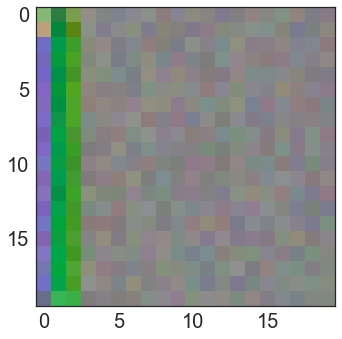

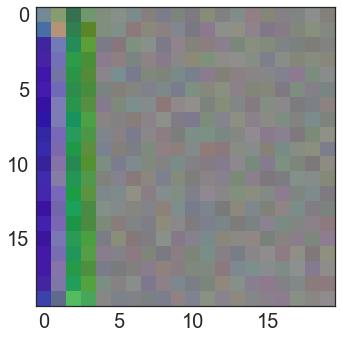

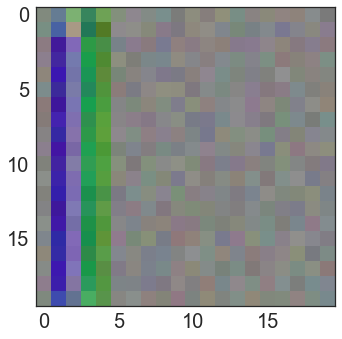

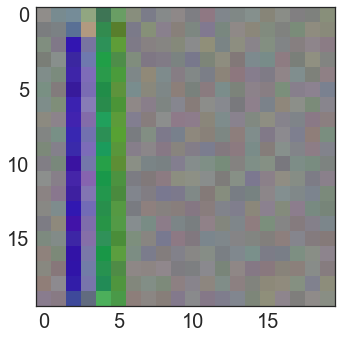

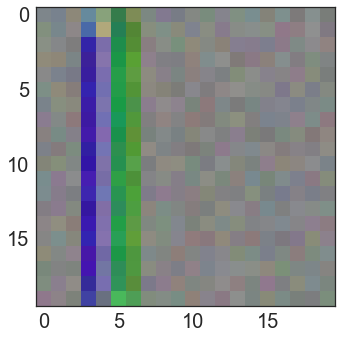

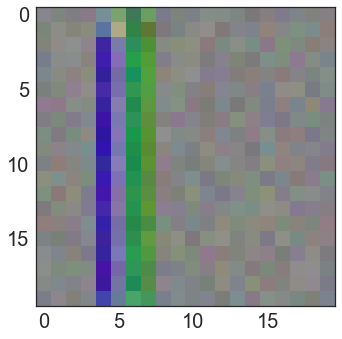

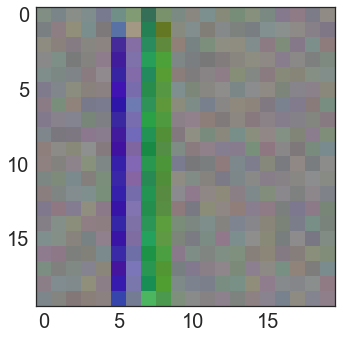

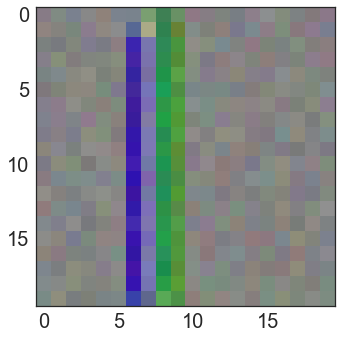

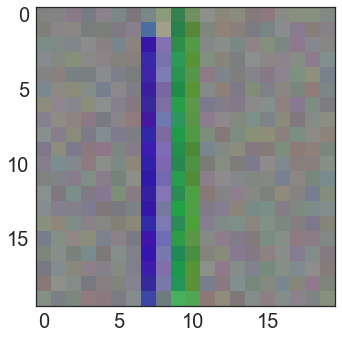

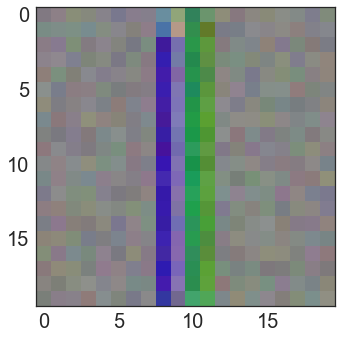

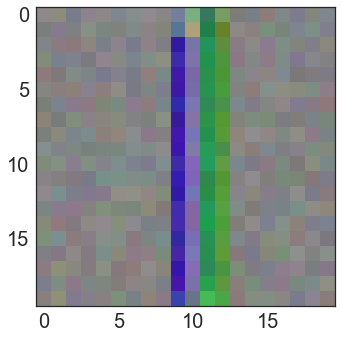

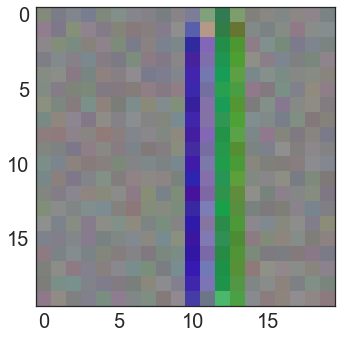

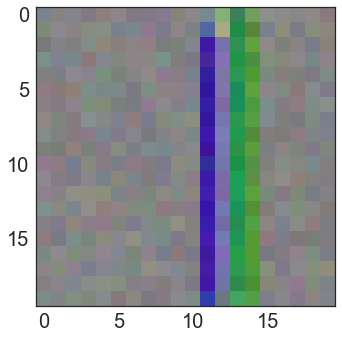

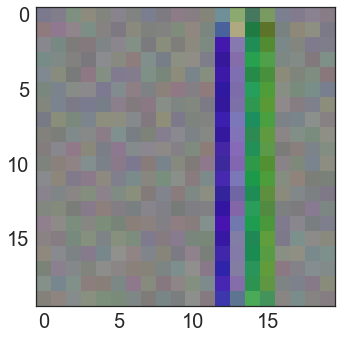

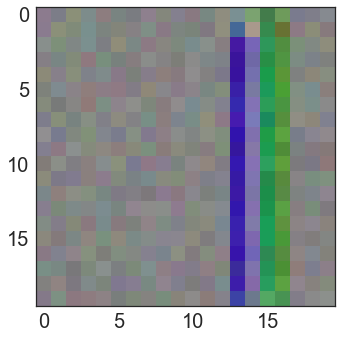

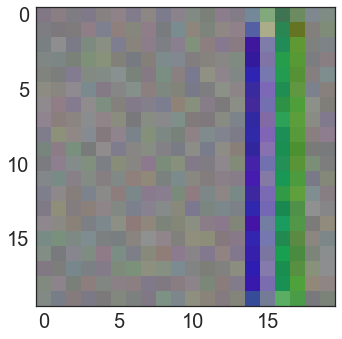

In [53]:
def show_filter_optimizer(filter_index):
    input_img = model.input # placeholder for actual input data

    conv_layer_output = model.layers[0].output
    loss = K.mean(conv_layer_output[:,...,filter_index])
    grads = K.gradients(loss, input_img)[0] 

    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    iterate = K.function([input_img], [loss, grads])

    
    img_width = 20
    img_height = 20
    input_img_data = np.random.random((1, 5, img_width, img_height)) * 20 + 128.
    step = 1

    optimization_steps = 20
    for i in range(optimization_steps):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    
    img = input_img_data[0]
    img = deprocess_image(img)
    return img
    
for i in range(16):
    plt.figure()
    img = show_filter_optimizer(i)
    plt.imshow(img[:,:,:3])

Huh. Not really sure what to make of that. It looks like one filter trying to mimic translational invariance?  But shouldn't my images be centered on the galaxy?  And even if there is a translational issue, why is this feature so clearly linear in one preferred direction?